## Libraries

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


In [ ]:
import os, string
import numpy as np
import pandas as pd
from PIL import Image
import requests

#from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset
from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load testing dataset

In [ ]:
image_path = "/content/drive/MyDrive/datasets/pokemon_hf_png"
caption_path = "/content/drive/MyDrive/datasets/pokemon_caption_hf.csv"

In [ ]:
imagename_df = pd.DataFrame(os.listdir(image_path))
imagename_df.columns = ['filename']
imagename_df['pokedex'] = imagename_df['filename'].str.replace('.png', "")
imagename_df['filename'] = imagename_df['filename'].transform(lambda x: image_path + "/" + x)

caption_df = pd.read_csv(caption_path)
caption_df['pokedex'] = caption_df['pokedex'].astype(str)
caption_df.drop(caption_df.columns[[0]],axis=1,inplace=True)

dataset_df = imagename_df.merge(caption_df, how='left', on='pokedex')
dataset_df = dataset_df[['filename', 'caption']].rename(columns={"caption": "text", "filename": "image"})
dataset_df.head()

,image,text
0,/content/drive/MyDrive/datasets/pokemon_hf_png...,a red and white ball with an angry look on its...
1,/content/drive/MyDrive/datasets/pokemon_hf_png...,a drawing of a green pokemon with red eyes
2,/content/drive/MyDrive/datasets/pokemon_hf_png...,a bunch of balls with faces drawn on them
3,/content/drive/MyDrive/datasets/pokemon_hf_png...,a cartoon character with a potted plant on his...
4,/content/drive/MyDrive/datasets/pokemon_hf_png...,a green and yellow toy with a red nose


In [ ]:
def gen():
    for index, row in dataset_df.iterrows():
      yield {"text":row["text"], "image":Image.open(row['image'])}
dataset = Dataset.from_generator(gen).shuffle(seed=123)
dataset = dataset.train_test_split(test_size=0.1, shuffle = False)

Generating train split: 0 examples [00:00, ? examples/s]

a cartoon green fish with a big smile on it's face


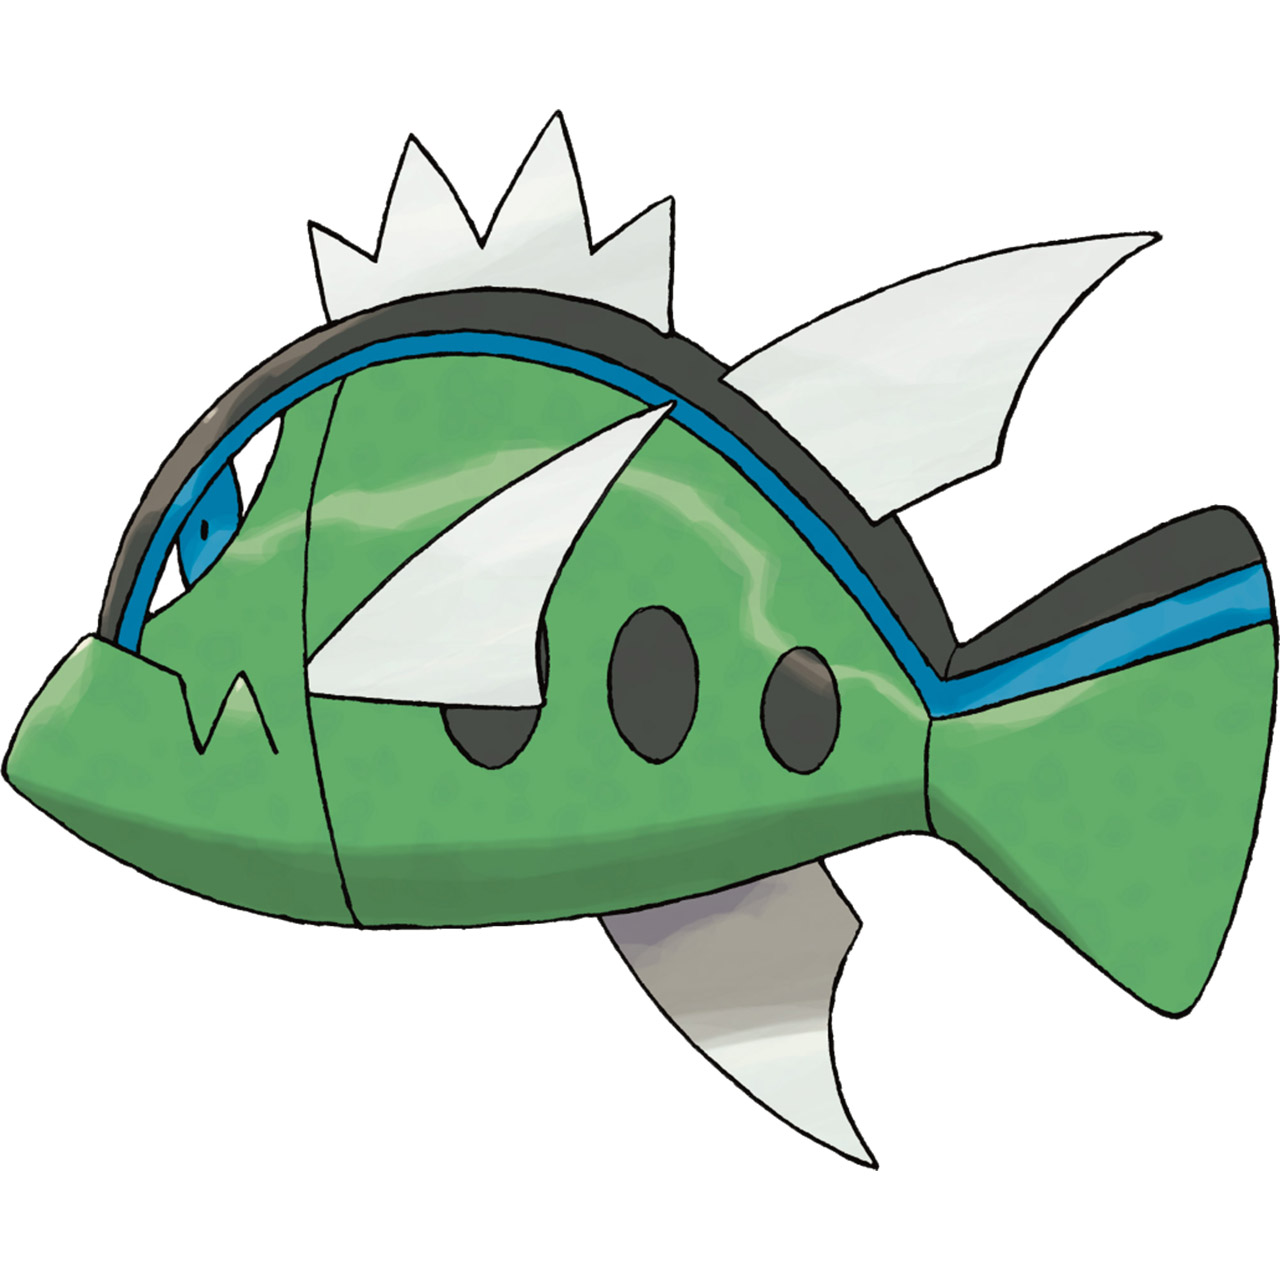

a cartoon bird with a hat on its head


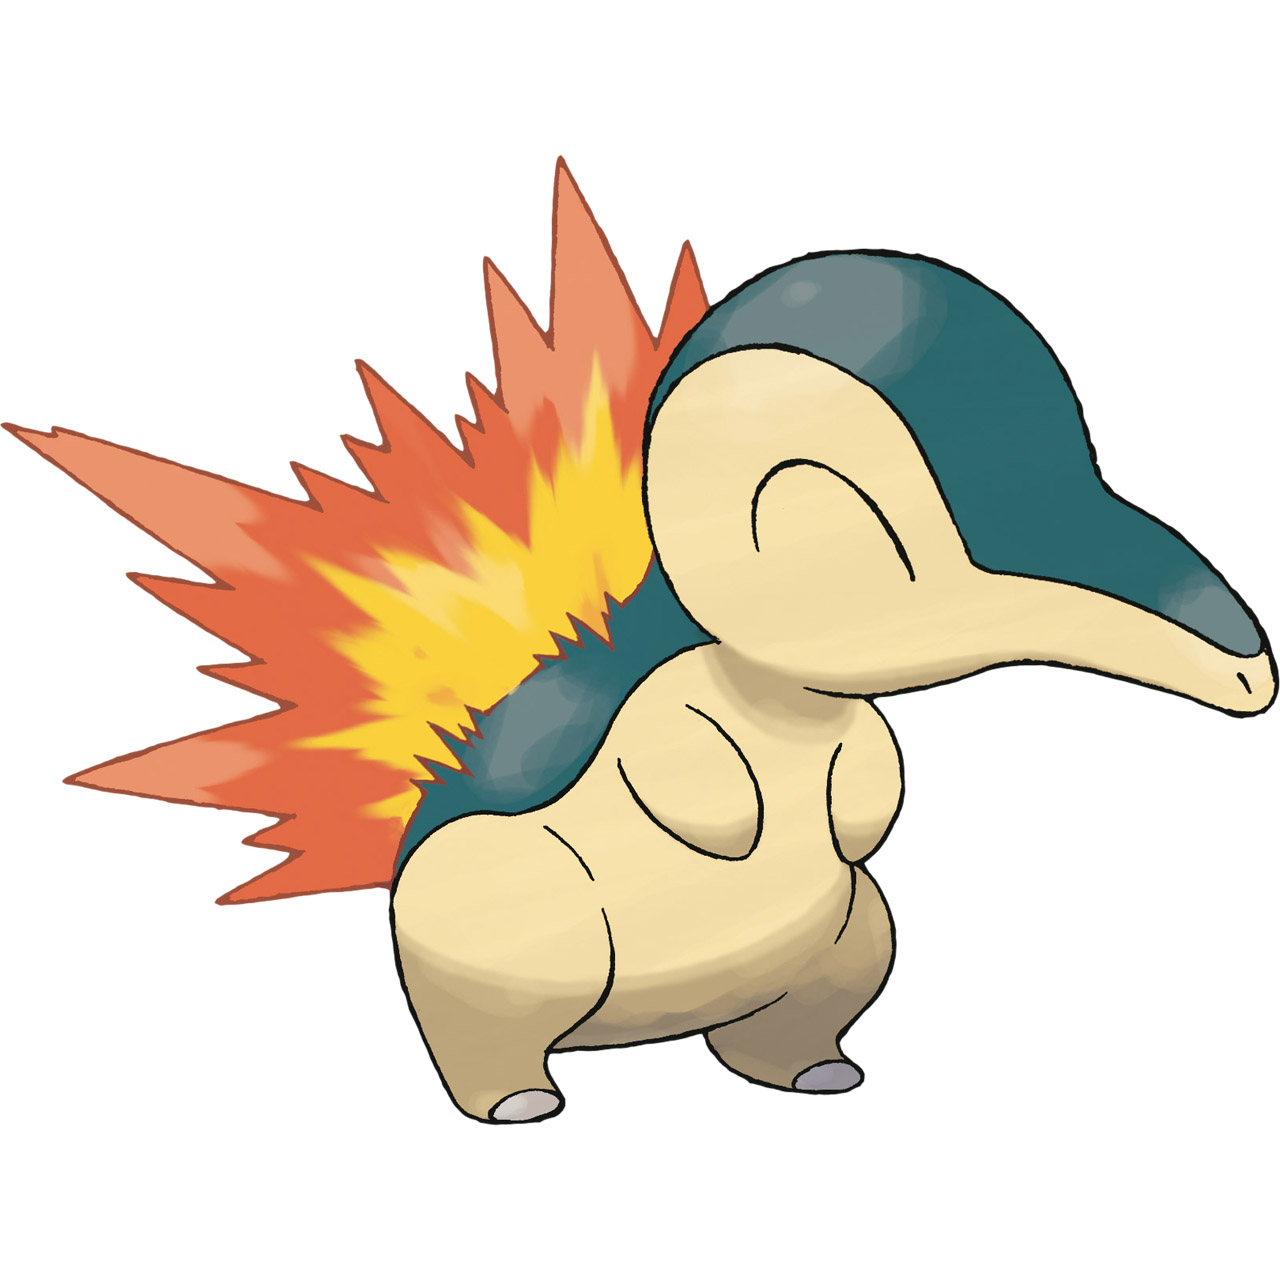

In [ ]:
print(dataset["train"][0]["text"])
display(dataset["train"][0]["image"])
print(dataset["test"][0]["text"])
display(dataset["test"][0]["image"])

## Load fine-tuned model and predict

In [ ]:
peft_model_id = "/content/drive/MyDrive/Pretrained Models/blip2_easy_4"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [ ]:
generated_captions = []
print(len(dataset["test"]))


for i, example in enumerate(dataset["test"]):
  print(i)
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  generated_captions.append(generated_caption)

84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [ ]:
save_array = []
for i, example in enumerate(dataset["test"]):
  save_array.append([example["text"], generated_captions[i]])
save_array

dataframe = pd.DataFrame(save_array)
dataframe.to_csv("/content/drive/MyDrive/result/blip_easy_5.csv")

In [ ]:
save_array

[['a cartoon bird with a hat on its head',
  "a drawing of a pokemon with a fire coming out of it's mouth"],
 ['a cartoon character in a karate outfit',
  'a drawing of a red and white character'],
 ['a drawing of a cat with a pink tail',
  'a drawing of a white and pink pokemon'],
 ['a drawing of a pokemon with a hat on top of it',
  'a drawing of a pokemon with a hat on'],
 ['a drawing of a small dog with big eyes',
  'a drawing of a dog with a blue coat'],
 ['a drawing of a very cute looking caterpillar',
  'a drawing of a cartoon character with a hat on'],
 ['a blue and black chandelier with flames coming out of it',
  'a drawing of a blue and black candle'],
 ['a drawing of a blue and red pokemon character',
  'a drawing of a cartoon character flying through the air'],
 ['a cartoon of a crescent moon with a pink eye',
  'a drawing of a moon with a pink eye'],
 ['a paper model of a tortoise shell',
  'a drawing of a blue and yellow pokemon'],
 ['a yellow and black butterfly on a wh